## Contexte

On souhaiterais pouvoir prévoir les pics de pollutions dans l'air de façon journalière. Plus exactement, il s'agit d'estimer la concentration de certains métaux dans l'air. Nous disposons pour ce faire d'un jeu de données de mesures horaires de la concentration de différents métaux dans l'air dans une ville italienne. Le dataset est disponible ici : https://archive.ics.uci.edu/ml/datasets/Air+Quality.

In [1]:
## Import des librairies
import sys # Load packages
sys.path.append('../')

import pickle # Load data

import aquarel # Graphiques
theme = aquarel.load_theme("arctic_dark")
theme.apply()

import pandas as pd # Datasets
import numpy as np # Datasets

from sktime.forecasting.model_selection import temporal_train_test_split

from src.analysis_tools import plot_columns, plot_boxplot, plot_correlations, estimate_gaussian,\
    compute_indicators, plot_all_acf_pacf, acf_pacf_plot, plot_results_cross_val, plot_forecast
from src.preprocess_and_modelling_tools import dataset_nan_imputer, cross_validation, get_prevision_gb, statistical_evaluation

In [2]:
# Thème graphique
theme = aquarel.load_theme("arctic_dark")
theme.apply()

In [3]:
dataset = pd.read_csv("../data/AirQualityUCI.csv", sep=";", index_col="Date")

COLORS = {k: f"C{v}" for (v,k) in enumerate(dataset.columns)}

In [4]:
dataset.drop("Time", inplace = True, axis = 1)
dataset = dataset[[x for x in dataset.columns if "pt08" in x.lower()]]

Nous ne nous concentrerons dans notre étude que sur les variables PT08._ allant de 1 à 5, correspondant aux mesures de certains métaux dans l'air (à savoir le dioxyde d'étain, le titane, le trioxyde de tungstène, ...). Cela car les autres variables présentent ou un grand nombre de valeurs aberrantes, ou présentent moins d'intérêt à être modélisées. Ces mesures étant fortement corrélées, nous nous focaliserons sur une seule pour la modélisation (les autres étant déductible de la prévision).

In [5]:
dataset = dataset[[x for x in dataset.columns if "pt08" in x.lower()]]

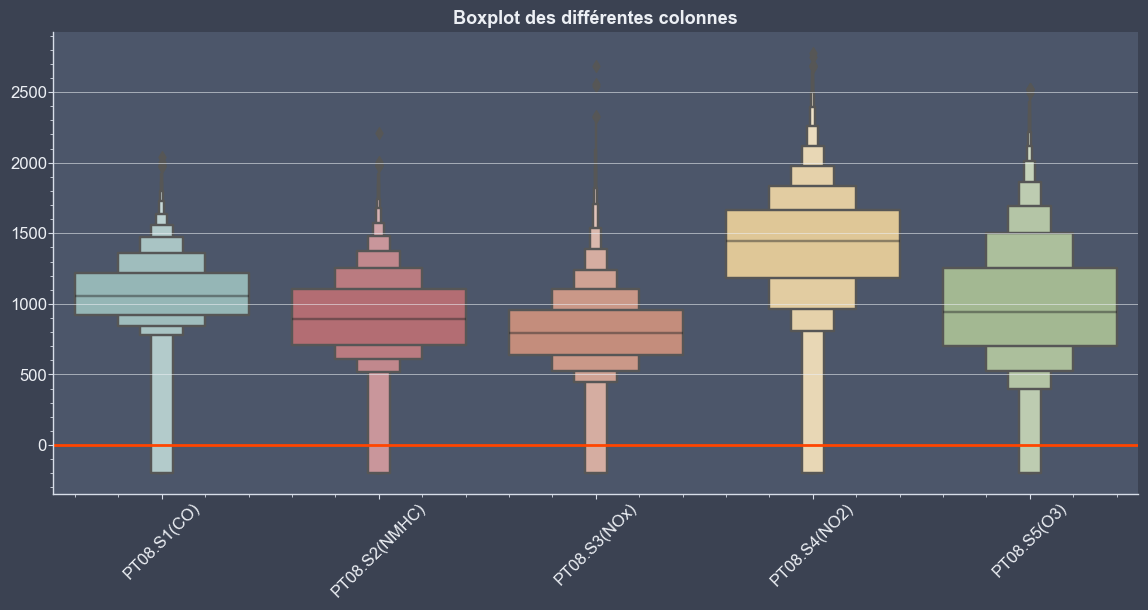

In [6]:
plot_boxplot(dataset, threshold=0)

Note : Les mesures ne pouvant être négatives, les données doivent avoir été imputées avec des valeurs négatives. Nous allons essayer de les reconstruire.

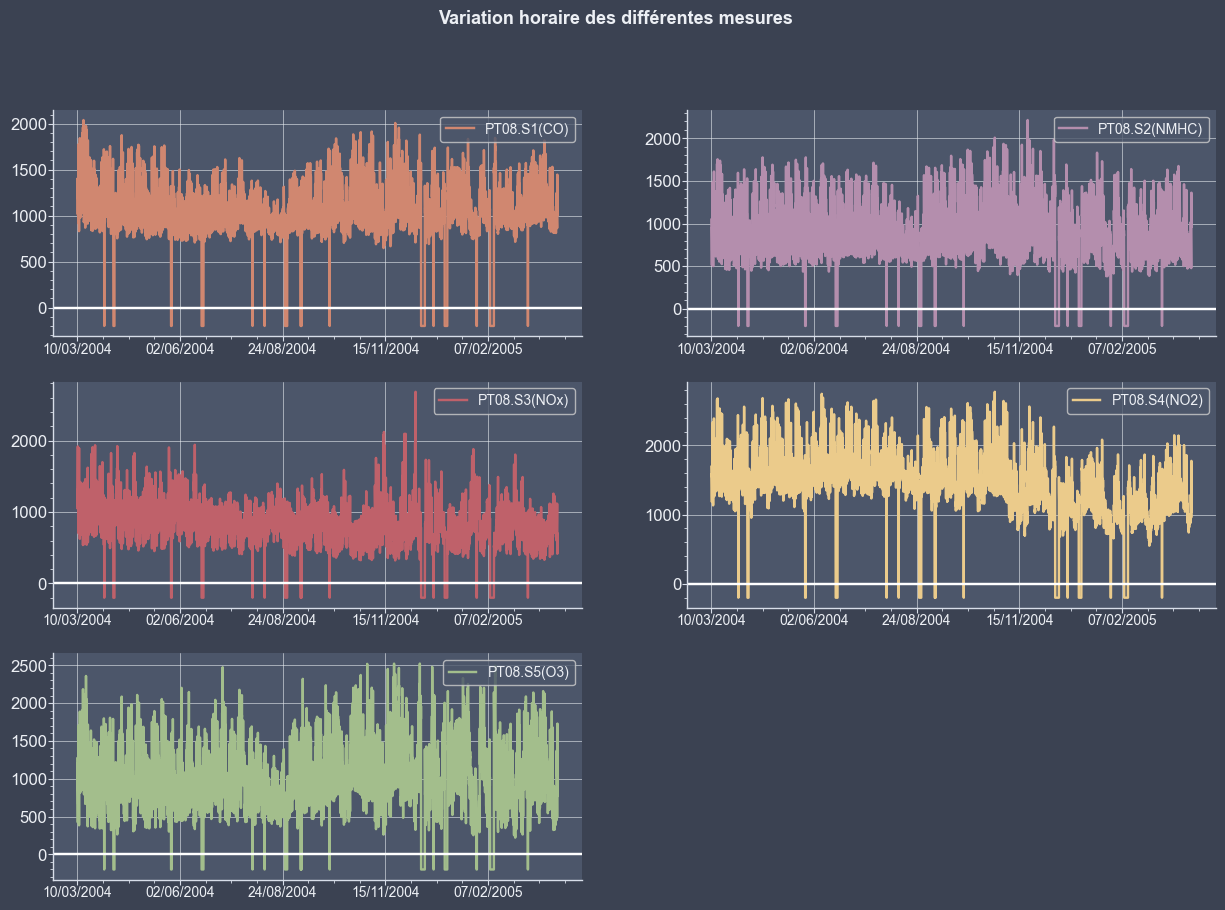

In [7]:
plot_columns(dataset, figsize = (15, 5), title = "Variation horaire des différentes mesures", COLORS = COLORS)

In [8]:
# passage des valeurs en deça de 0 (aberrantes) en NaN
dataset = dataset.apply(lambda x:np.where(x < 0, np.nan, x))

In [9]:
# recupération des index NaN pour chaque colonne
nan_indexes = {k:v for k,v in zip([col for col in dataset.columns], [dataset[dataset[col].isna()].index for col in dataset.columns])}

## Imputing

In [10]:
# Imputing
dataset = dataset_nan_imputer(dataset)

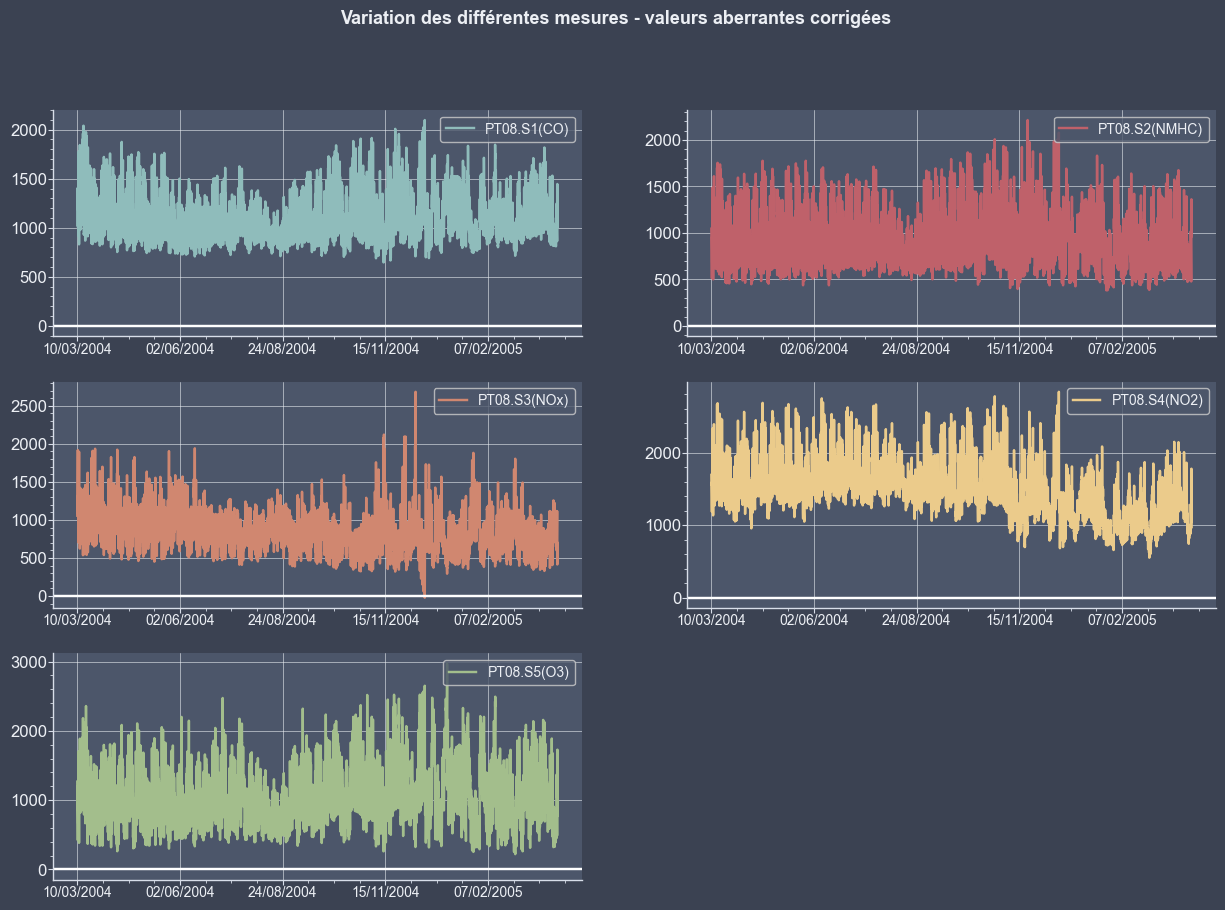

In [11]:
plot_columns(dataset, title = "Variation des différentes mesures - valeurs aberrantes corrigées")

## Analyse statistique

### Corrélations

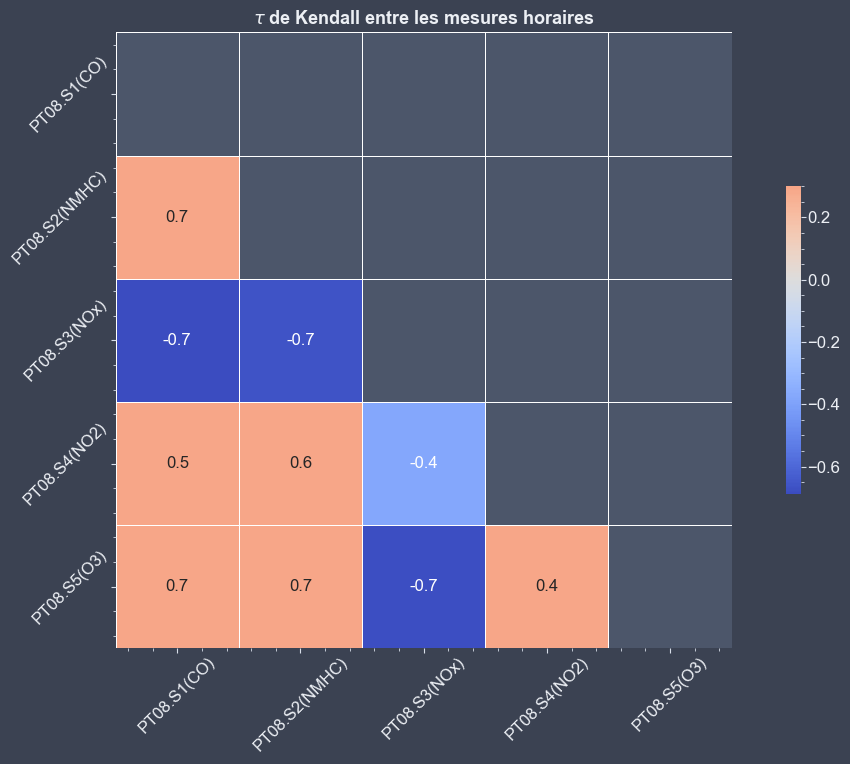

In [12]:
plot_correlations(dataset, title = r"$\tau$ de Kendall entre les mesures horaires")

Comme dit précédemment, les variables sont très corrélées entre elles. Nous choisissons donc de n'en modéliser qu'une seule, représentative des autres.

In [13]:
compute_indicators(dataset)

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
Exposant de Lyapunov,0.007696,0.002931,0.001876,-0.005817,0.002802
Exposant de Hurst,0.819012,0.743722,0.800534,0.839331,0.845105
Detrended Fluctual Analysis,0.955668,0.884747,0.957315,0.974844,0.976692
Sample Entropy,1.038074,1.120527,1.058905,0.887781,1.054498
Dickey-Fuller Augmenté,Stationnaire,Stationnaire,Stationnaire,Stationnaire,Stationnaire


<b>Analyse des mesures</b>
<ul>
<br>
<li>
La première chose à remarquer, c'est que l'ensemble de nos séries sont stationnaires, ce qui est une propriété intéressante pour la suite.
</li>
<br>
<li>
Ensuite concernant le "Sample entropy", cette mesure n'est pas directement interpretable. En revanche, on peut voir que la série la plus "simple" à modéliser serait la série PT08.S4, celle voyant son entropie la plus faible. Formulé autrement, c'est cette mesure qui contient en elle même le plus d'informations pour prédire sa continuité.
</li>
<br>
<li>
Le "Detrended Fluctual Analysis" et l'exposant de Hurst jouent sensiblement le même rôle. Ici, ils nous permettent d'affirmer que les séries ne suivent pas des browniens fractionnaires, qui sont par nature très difficile à modéliser. De plus, nos séries sont persistentes c'est à dire qu'elles présentent toutes une tendance et ne tendent pas à faire un retour à la moyenne.
</li>
<br>
<li>
Enfin, concernant l'exposant de Lyapunov, ce dernier nous informe sur la tendance chaotique d'une série temporelle. Plus spécifiquement, plus ce dernier est significativement supérieur à 0, plus la série sera chaotique.
</li>
</ul>
<br>
Au vu de ces observations, nous choisissons de modéliser comme variable représentative des autres la variable <b>PT08.S4</b>, car c'est celle qui paraît le moins sensible a des variations chaotiques et qui voit sa sample entropy minimisée.

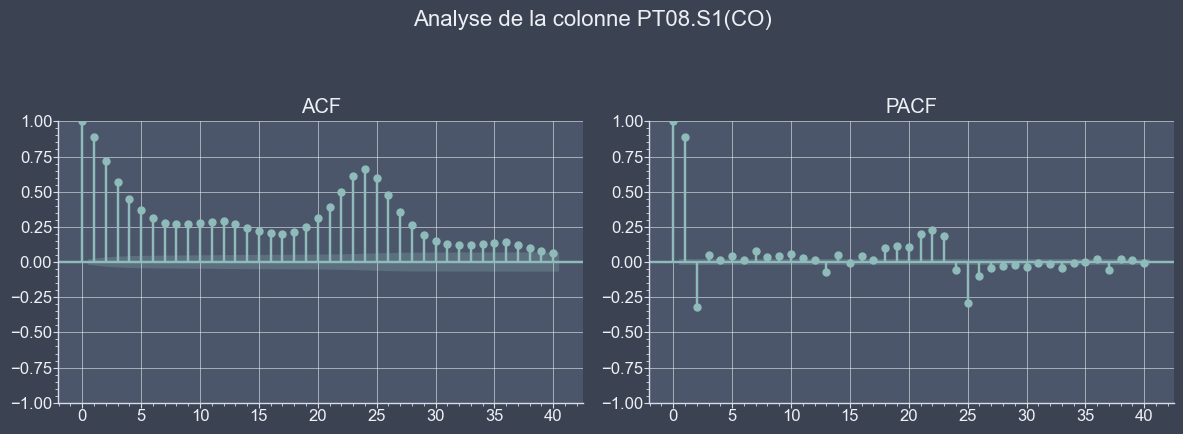

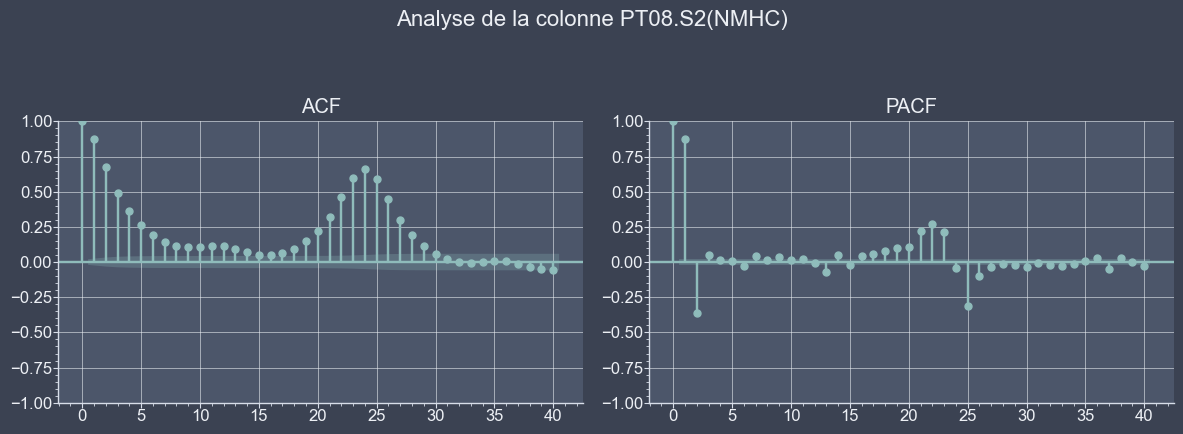

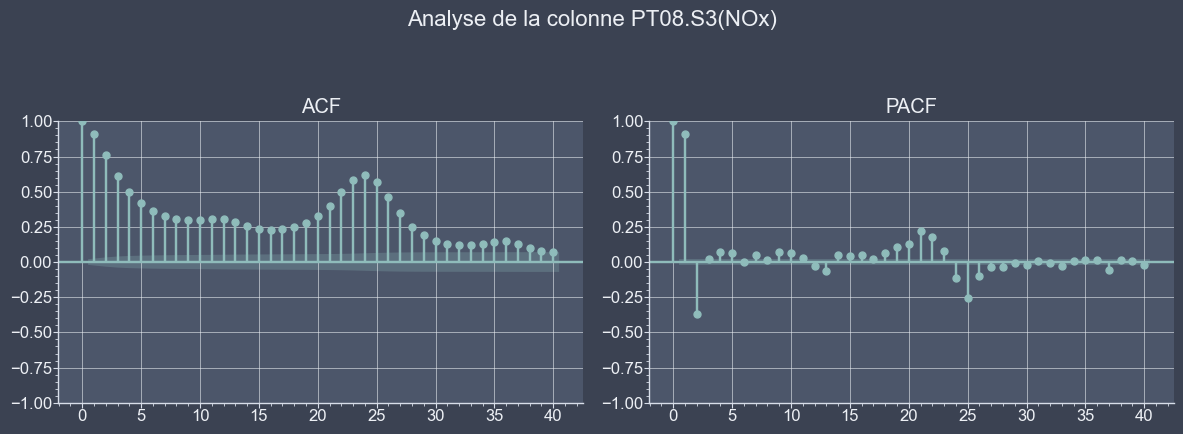

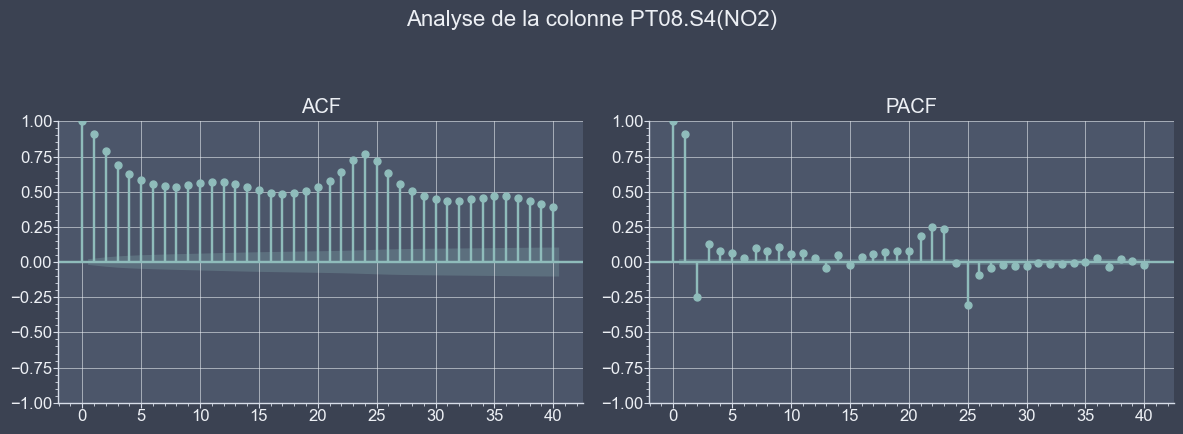

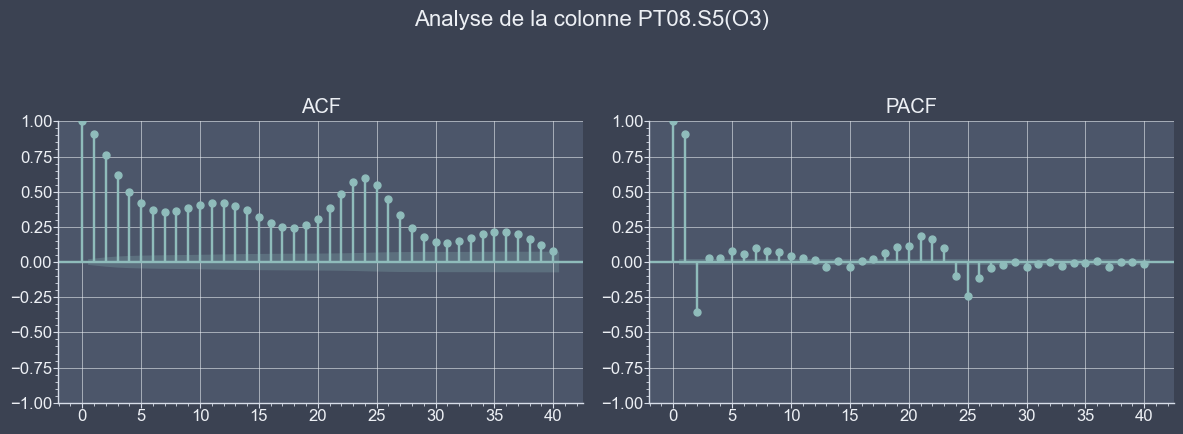

In [14]:
plot_all_acf_pacf(dataset)

Note : On remarque pour toutes les colonnes une saisonnalité journalière forte.

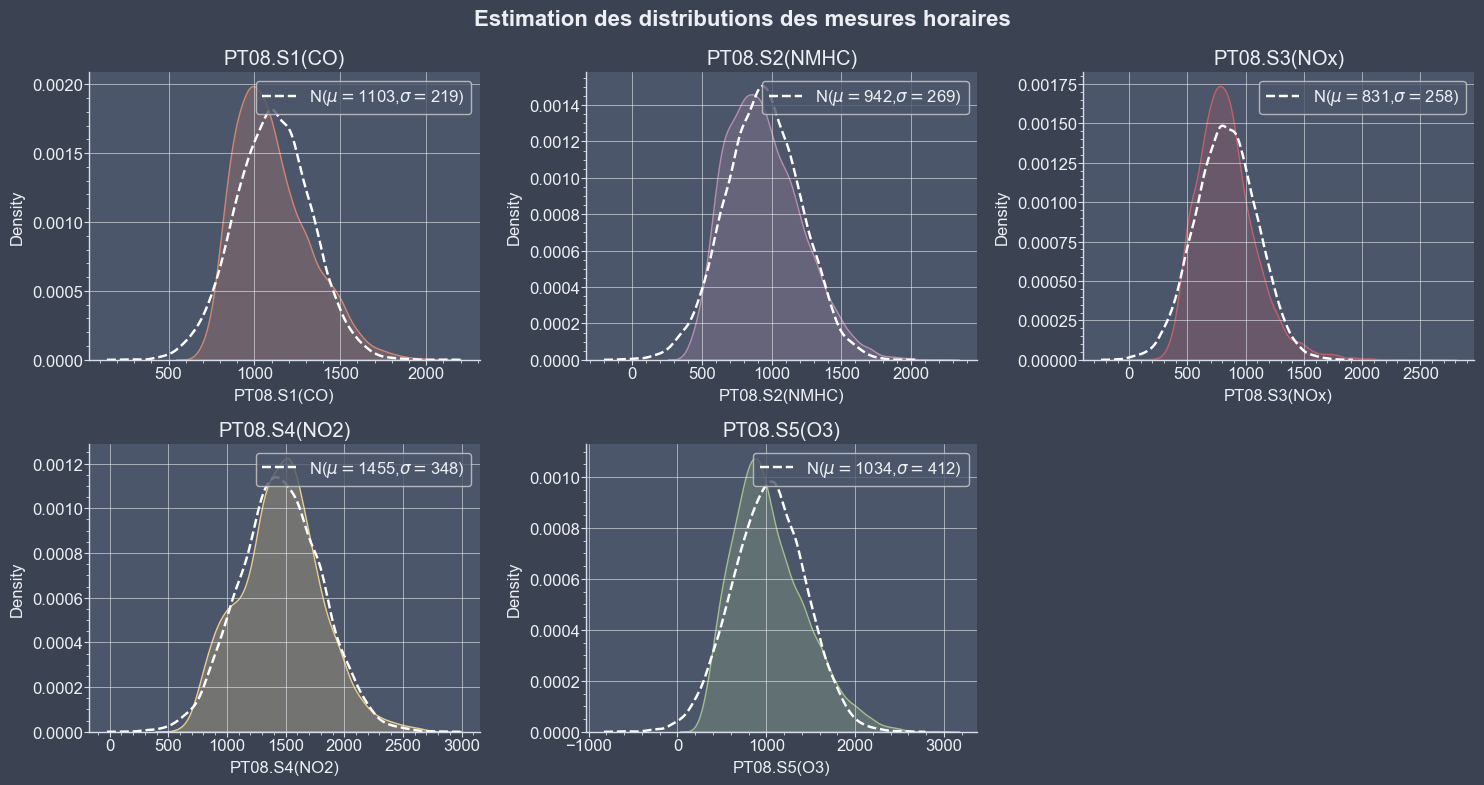

In [15]:
estimate_gaussian(dataset, title = "Estimation des distributions des mesures horaires", colors = COLORS)

Le test de Dickey-Fuller nous indique que nos données sont stationnaires, i.e au sens strict, que la distribution de probabilité est la même au fil du temps. On peut essayer d'estimer ces distributions avec une loi normale (au vu de la forme des courbes). Sur les graphiques ci-dessus, nous observons que l'estimation par la loi normale (en point-tillés) semble assez adéquate pour représenter nos données. En revanche, la convergence de la moyenne empirique en espérance mathématique n'est pas garantie compte tenu du fait de l'autocorrélation.<br><br>
Chose intéressante à remarquer, la nature bruitée des données horaires rends les données plus proches d'une gaussienne en terme de distribution que leurs aggrégations journalières.

## Passage en données journalières

In [16]:
daily_dataset = dataset.groupby(by = dataset.index).mean().sort_index(ascending = False)
y = daily_dataset["PT08.S4(NO2)"]

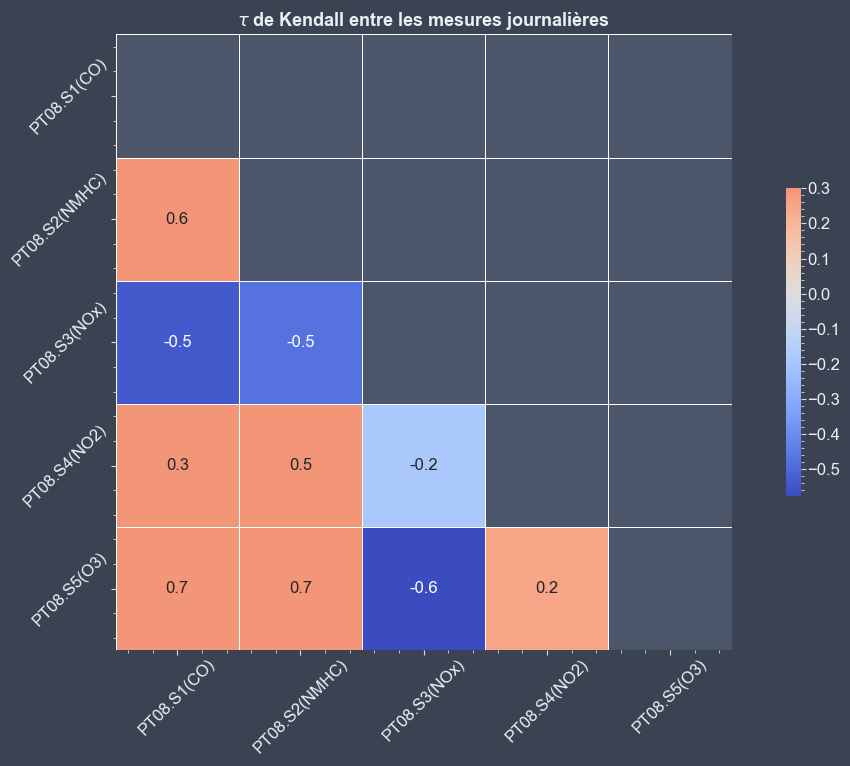

In [17]:
plot_correlations(daily_dataset, title = r"$\tau$ de Kendall entre les mesures journalières")

Les corrélations entre les mesures étant importantes, nous allons nous concentrer sur la modélisation d'une seule mesure : "PT08.S4(NO2)"; le trioxyde de tungstène. Ce choix est motivé par le calcul de l'exposant de Lyapunov ainsi que par l'entropie de l'échantillon.<br><br>
 Les autres mesures seront ainsi déductibles (positivement ou négativement) de notre prévision. Pour rappel, nous ne souhaitons estimer que les pics de pollution.

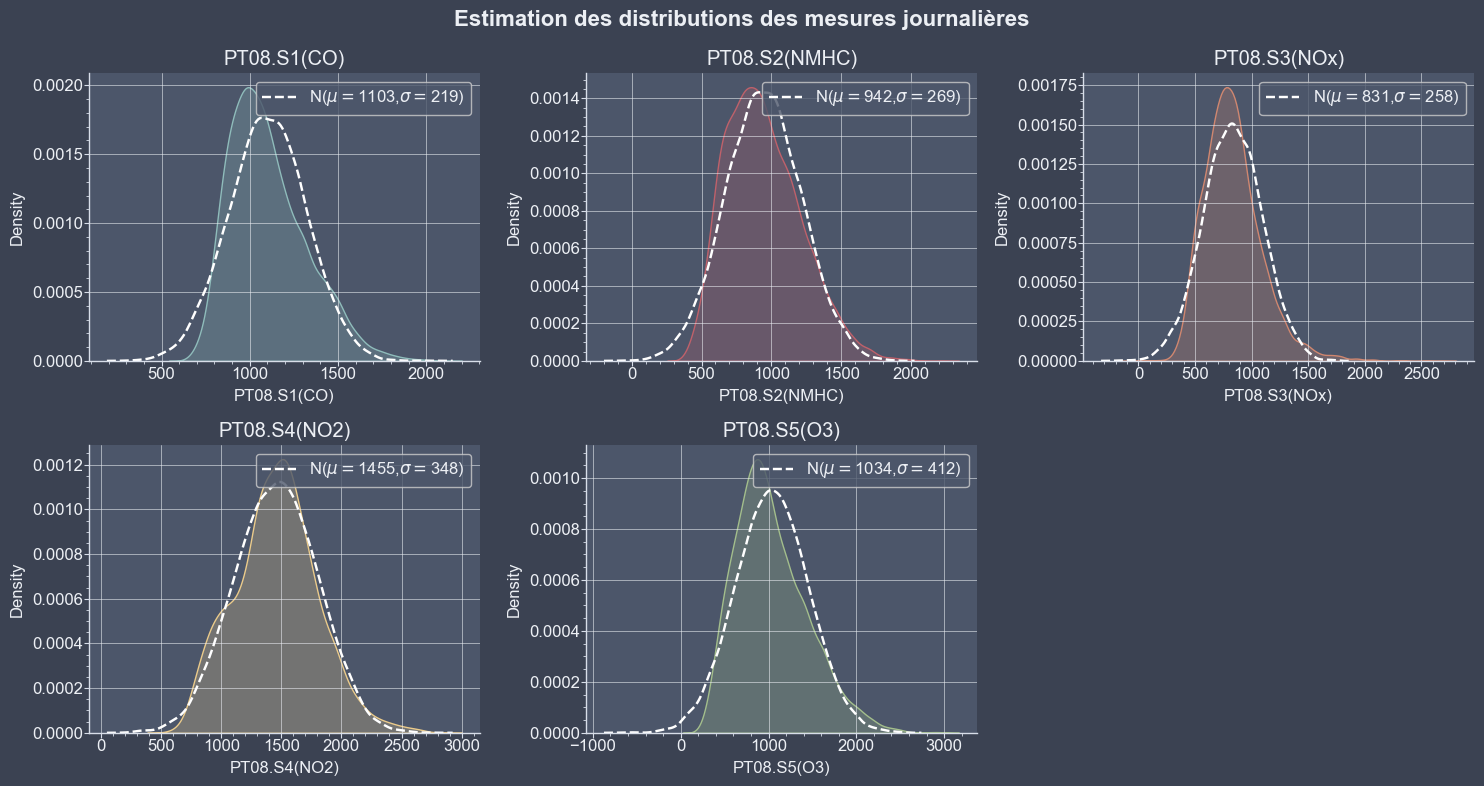

In [18]:
estimate_gaussian(dataset, title = "Estimation des distributions des mesures journalières")

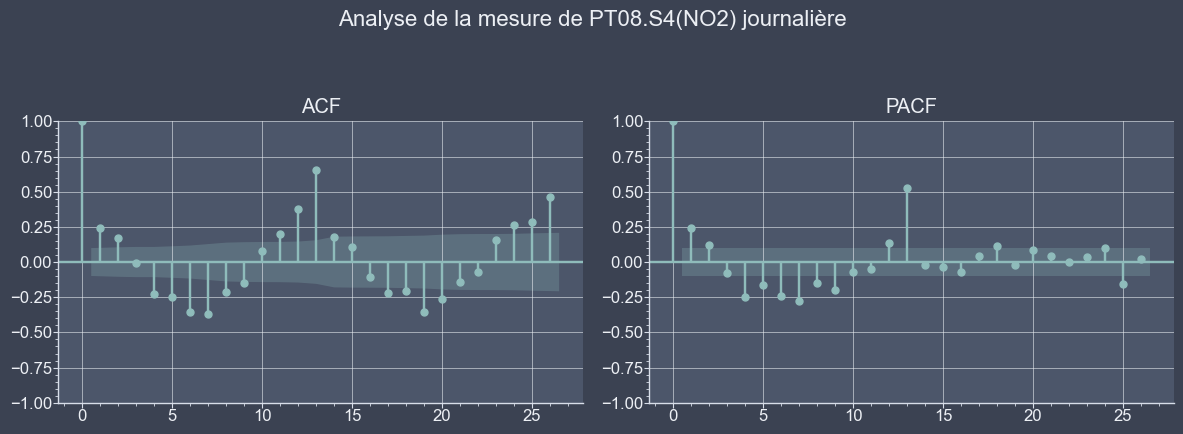

In [19]:
acf_pacf_plot(vector = y, global_title=f"Analyse de la mesure de {y.name} journalière")

## Cross-validation

La cross validation se fait à la fois en testant différent horizons de prévisions, mais également pour chaque horizon en testant plusieurs plages possibles. La MAE moyenne par horizon, ainsi que les MAE maxs et mins pour chaque horizon et chaque modèles testés (SARIMAX, LGBM direct, LGBM récursif, Ridge direct, Ridge récursif, et naïf comme baseline) sont enregistrés dans des dictionnaires et nous servent ensuite pour choisir le meilleur modèle.

In [20]:
# errors, max, mins = cross_validation(y, save = True) # Execution de la cross validation

# Chargement des résultats de la cross validation
file = open('../pickle/errors.pkl','rb')
errors = pickle.load(file)
file.close()

file = open('../pickle/maxs.pkl','rb')
maxs = pickle.load(file)
file.close()

file = open('../pickle/mins.pkl','rb')
mins = pickle.load(file)
file.close()

In [21]:
## Voici l'output de la fonction "cross_validation". La cellule mets du temps à s'executer (109 minutes) nous avons donc sauvegardé les résultats dans des fichiers pickle.
#   0%|          | 0/16 [00:00<?, ?it/s]
# Number of shift (horizon = 1) : 76
#   6%|▋         | 1/16 [01:59<29:46, 119.08s/it]
# Number of shift (horizon = 6) : 71
#  12%|█▎        | 2/16 [05:41<42:01, 180.14s/it]
# Number of shift (horizon = 11) : 66
#  19%|█▉        | 3/16 [11:37<56:25, 260.45s/it]
# Number of shift (horizon = 16) : 61
#  25%|██▌       | 4/16 [18:58<1:06:19, 331.60s/it]
# Number of shift (horizon = 21) : 56
#  31%|███▏      | 5/16 [31:09<1:27:12, 475.68s/it]
# Number of shift (horizon = 26) : 51
#  38%|███▊      | 6/16 [41:11<1:26:25, 518.58s/it]
# Number of shift (horizon = 31) : 46
#  44%|████▍     | 7/16 [50:25<1:19:32, 530.24s/it]
# Number of shift (horizon = 36) : 41
#  50%|█████     | 8/16 [59:59<1:12:31, 543.89s/it]
# Number of shift (horizon = 41) : 36
#  56%|█████▋    | 9/16 [1:09:28<1:04:22, 551.75s/it]
# Number of shift (horizon = 46) : 31
#  62%|██████▎   | 10/16 [1:18:30<54:52, 548.80s/it] 
# Number of shift (horizon = 51) : 26
#  69%|██████▉   | 11/16 [1:26:49<44:28, 533.73s/it]
# Number of shift (horizon = 56) : 21
#  75%|███████▌  | 12/16 [1:36:04<36:00, 540.20s/it]
# Number of shift (horizon = 61) : 16
#  81%|████████▏ | 13/16 [1:42:12<24:24, 488.07s/it]
# Number of shift (horizon = 66) : 11
#  88%|████████▊ | 14/16 [1:46:28<13:55, 417.98s/it]
# Number of shift (horizon = 71) : 6
#  94%|█████████▍| 15/16 [1:48:55<05:36, 336.23s/it]
# Number of shift (horizon = 76) : 1
# 100%|██████████| 16/16 [1:49:21<00:00, 410.12s/it]

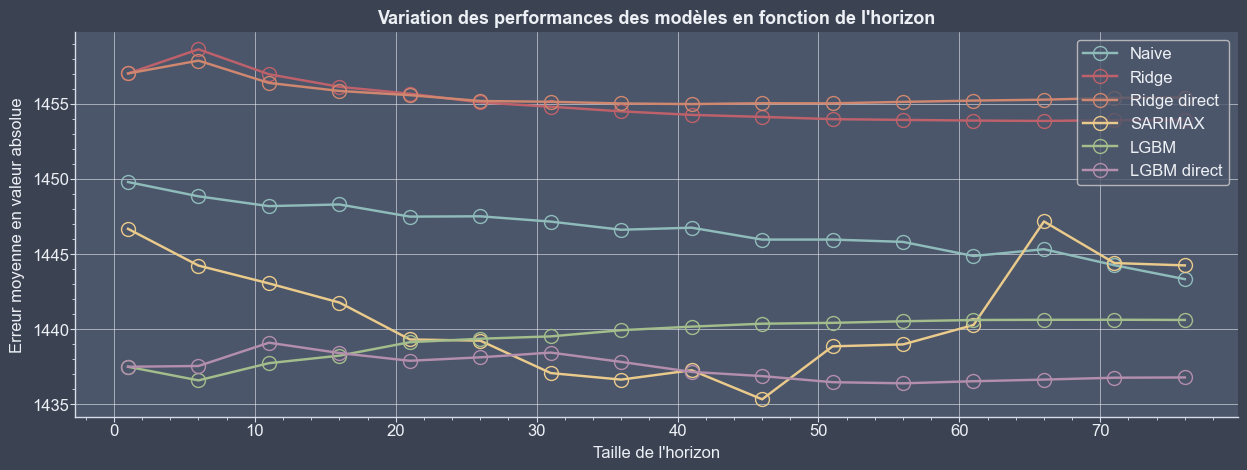

In [22]:
MAX_TEST_SIZE = int(.2 * len(y))
MODELS = ["Naive", "Ridge", "Ridge direct", "SARIMAX", "LGBM", "LGBM direct",]

plot_results_cross_val(errors = errors, maxs = maxs, mins = mins, MAX_TEST_SIZE=MAX_TEST_SIZE)

On choisit de retenir le LightGBM direct pour la modélisation finale au vu des résultats globalement meilleurs par rapport aux autres modèles selon le critère de la MAE.

### Modélisation finale et évaluation statistique

In [23]:
# Splitting du dataset final pour évaluer le modèle choisit
y_train, y_test = temporal_train_test_split(y, test_size=MAX_TEST_SIZE)

Pour la modélisation finale, nous choississons d'opter pour une régression quantile plutôt qu'une simple modélisation ponctuelle. Bien que la minimisation de loss Pinball risque d'être biaisée, l'IC généré nous sert à avoir un ordre d'idée. Une amélioration pourrait être d'aller vers des méthodes plus adaptées comme la méthode de Jacknife++ ou de la conformal prediction.

In [24]:
lower, pred, upper = get_prevision_gb(y_train.values, len(y_test))

RMSE : 368
RMSE normalisée : 9.58%


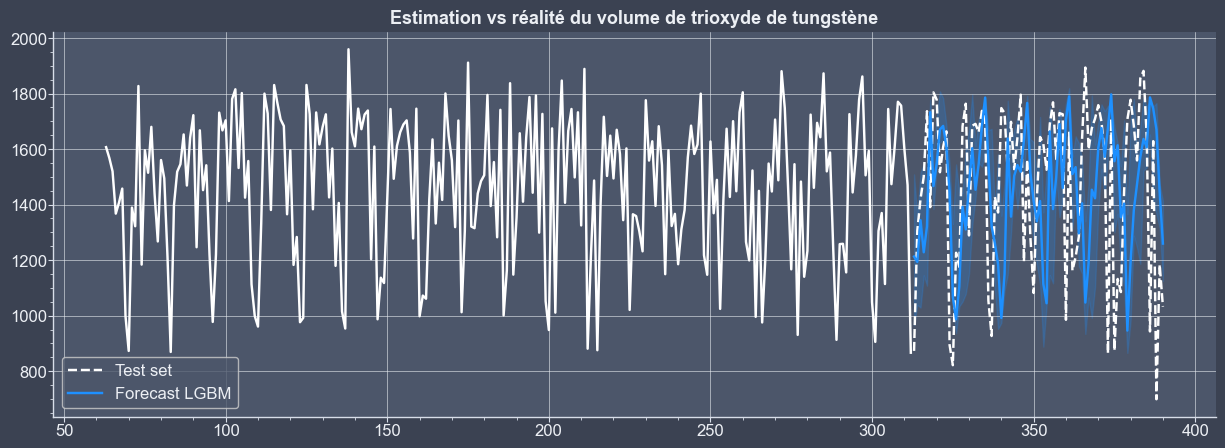

In [25]:
# Forecasting du jeu de test

plot_forecast(pred, lower, upper, y_train.values, y_test.values)

On observe que la prévision semble assez bien suivre la réalité. Le modèle peut donc servir à détecter les pics de pollution sur cette variable et d'en déduire les pics sur les autres variables compte tenu de la corrélation forte qu'il existe entre nos mesures. Nous pouvons donc estimer avec une bonne exactitude les périodes de hausse de la pollution de l'air par certains métaux.

La RMSE obtenue semble plutôt bonne, en revanche pour évaluer la performance statistique de notre modèle, il nous faut évaluer la probabilité d'obtenir notre statistique observée dans un contexte de hasard. Pour ce fait, nous allons utiliser la propriété de stationnarité validée par le test de Dickey-Fuller augmenté. Pour rappel, la stationnarité forte signifie que nos observations sont issues de la même distribution de probabilité. Nous avons essayé d'estimer cette distribution par une loi normale, ce qui fonctionnait bien avec les données horaires mais qui fonctionne moins bien avec les données journalières. Nous choissons donc d'utiliser une autre méthode : On permute aléatoire (un nombre suffisant de fois) notre jeu de test et on recalcule la RMSE sur ces permutations. Ce faisant nous nous plaçons sous l'hypothèse nulle de distribution aléatoire. Ensuite, on regarde la part des RMSE supérieure à la RMSE initiallement observée : c'est la probabilité pour que notre statistique soit dûe au hasard.

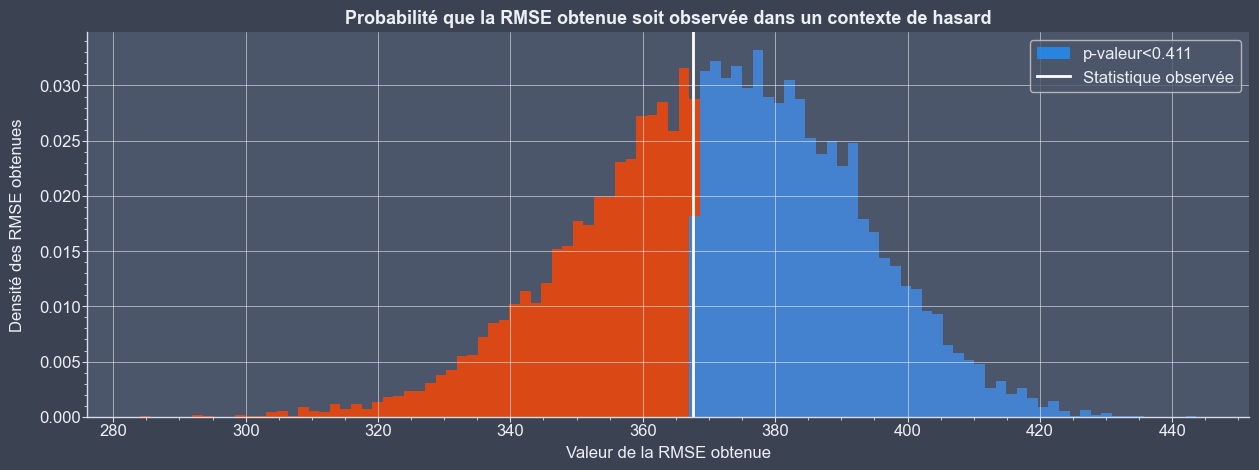

La p valeur est de 0.411


In [26]:
p_val = statistical_evaluation(pred, y_test)
print(f"La p valeur est de {p_val:.3f}")

Malgré la bonne RMSE en volume, le résultat obtenu n'est pas statistiquement très bon, cela car la probabilité pour que la RMSE obtenue soit observée dans un contexte de hasard est de 41%.